# Lotka-Volterra inference tests

In [69]:
import numpy as np
import corner
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

## Metrics evaluated on theta used for generation

In [70]:
def load_metrics(simulator='lotkavolterra',
                 method='maf',
                 label='',
                 reference_method='rascandal',
                 reference_label='',
                 single_theta=True,
                 n_runs=5):
    
    reference_path = '../../data/results/' + simulator + '/' + reference_method + '/'
    path = '../../data/results/' + simulator + '/' + method + '/'
    test_label = 'test_zoom_singletheta' if single_theta else 'test_zoom'
    
    # Reference likelihood
    log_p_references = []
    t_references = []
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p_references.append(np.load(reference_path + 'log_p_hat_' + test_label + reference_label + run_label + '.npy'))
            t_references.append(np.load(reference_path + 't_hat_' + test_label + reference_label + run_label + '.npy'))
        except FileNotFoundError as e:
            # print(e)
            pass
    log_p_references = np.array(log_p_references)
    log_p_reference = np.median(log_p_references, axis=0)
    t_references = np.array(t_references)
    t_reference = np.median(t_references, axis=0)
    
    # Calculate metrics
    expected_log_ps = []
    mses = []
    score_mses = []
    
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p = np.load(
                path + 'log_p_hat_' + test_label + label + run_label + '.npy'
            )
            log_p[~np.isfinite(log_p)] = -100.
            
            t = np.load(
                path + 't_hat_' + test_label + label + run_label + '.npy'
            )
            t[~np.isfinite(t)] = -100.
            
            expected_log_ps.append(
                1. / log_p.shape[0] * np.sum(log_p)
            )
            mses.append(
                mean_squared_error(log_p_reference, log_p)
            )
            score_mses.append(
                mean_squared_error(t_reference, t)
            )
        
        except FileNotFoundError as e:
            # print(e)
            pass
        
    expected_log_ps = np.array(expected_log_ps)
    mses = np.array(mses)
    score_mses = np.array(score_mses)
        
    # Calculate mean and std
    expected_log_p_mean = np.mean(expected_log_ps)
    expected_log_p_uncertainty = np.std(expected_log_ps) / len(expected_log_ps)**0.5
    
    mse_mean = np.mean(mses)
    mse_uncertainty = np.std(mses) / len(mses)**0.5
    
    score_mse_mean = np.mean(score_mses)
    score_mse_uncertainty = np.std(score_mses) / len(score_mses)**0.5
    
    return (expected_log_p_mean, expected_log_p_uncertainty,
            mse_mean, mse_uncertainty,
            score_mse_mean, score_mse_uncertainty)


In [71]:
sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

methods = ['maf', 'maf', 'scandal', 'scandal', 'rascandal', 'rascandal']
filenames = ['', '_mog', '_largealpha', '_mog', '', '_mog']
method_labels = ['MAF', 'MAF MoG', 'SCANDAL', 'SCANDAL MoG', 'RASCANDAL', 'RASCANDAL MoG']


In [75]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label='_model_zoom' +  filename + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_100000',
                single_theta=False
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_mean = metrics[:,:,0]
expected_log_p_uncertainty = metrics[:,:,1]
mse_mean = metrics[:,:,2]
mse_uncertainty = metrics[:,:,3]
score_mse_mean = metrics[:,:,4]
score_mse_uncertainty = metrics[:,:,5]


In [76]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label='_model_zoom' +  filename + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_100000',
                single_theta=True
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_st_mean = metrics[:,:,0]
expected_log_p_st_uncertainty = metrics[:,:,1]
mse_st_mean = metrics[:,:,2]
mse_st_uncertainty = metrics[:,:,3]
score_mse_st_mean = metrics[:,:,4]
score_mse_st_uncertainty = metrics[:,:,5]


## Plot

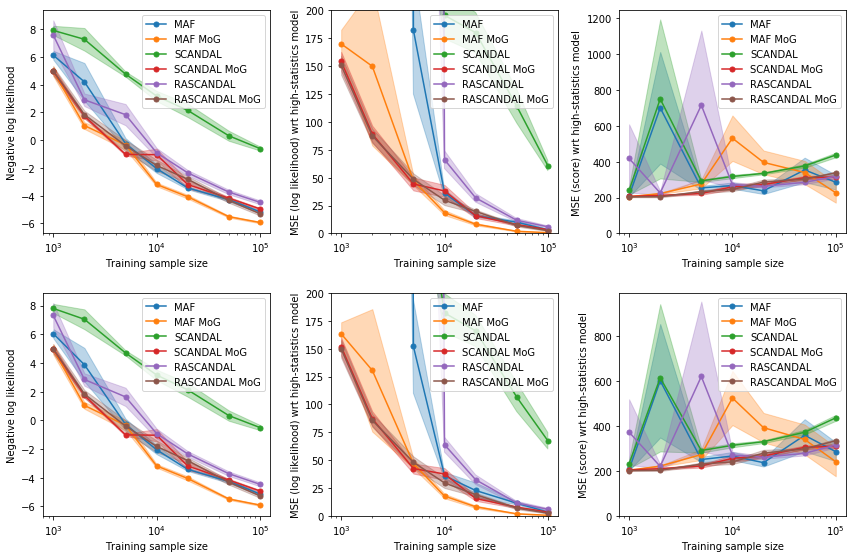

In [79]:
colors = ['C' + str(i) for i in range(10)]

fig = plt.figure(figsize=(12,8))



ax = plt.subplot(2,3,1)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_st_mean[m] - expected_log_p_st_uncertainty[m],
        - expected_log_p_st_mean[m] + expected_log_p_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,2)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_st_mean[m] - mse_st_uncertainty[m],
        mse_st_mean[m] + mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,200.)



ax = plt.subplot(2,3,3)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_st_mean[m] - score_mse_st_uncertainty[m],
        score_mse_st_mean[m] + score_mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)



ax = plt.subplot(2,3,4)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_mean[m] - expected_log_p_uncertainty[m],
        - expected_log_p_mean[m] + expected_log_p_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,5)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_mean[m] - mse_uncertainty[m],
        mse_mean[m] + mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,200.)



ax = plt.subplot(2,3,6)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_mean[m] - score_mse_uncertainty[m],
        score_mse_mean[m] + score_mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)
    
    

plt.tight_layout()
plt.show()


## Metrics on grid

In [82]:
def load_metrics_grid(simulator='lotkavolterra',
                      method='maf',
                      label='',
                      reference_method='rascandal',
                      reference_label='',
                      quantity='log_p_hat',
                      n_runs=5,
                      expectation_index=0):
    
    reference_path = '../../data/results/' + simulator + '/' + reference_method + '/'
    path = '../../data/results/' + simulator + '/' + method + '/'
    sample_label = 'test_zoom_singletheta_evaluated_on_grid_'
    
    # Reference likelihood
    log_p_references = []
    t_references = []
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p_references.append(np.load(reference_path + quantity + '_' + sample_label + reference_label + run_label + '.npy'))
        except FileNotFoundError as e:
            print(e)
            pass
    log_p_references = np.array(log_p_references)
    log_p_reference = np.median(log_p_references, axis=0)
    
    # Calculate metrics
    mses = []
    expected_log_p = []
    
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p = np.load(
                path + quantity + '_' + sample_label + label + run_label + '.npy'
            )
            
            n_infs = np.sum(~np.isfinite(log_p))
            if n_infs > 0:
                print('{} infs for {}'.format(n_infs, method))
            log_p[~np.isfinite(log_p)] = -100.
            
            mses.append(
                mean_squared_error(log_p_reference.flatten(), log_p.flatten())
            )
            
            expected_log_p.append(
                np.mean(log_p[expectation_index])
            )
        
        except FileNotFoundError as e:
            #print(e)
            pass
        
    mses = np.array(mses)
    expected_log_p = np.array(expected_log_p)
        
    # Calculate mean and std
    mse_mean = np.mean(mses)
    mse_uncertainty = np.std(mses) / len(mses)**0.5
    expected_log_p_mean = np.mean(expected_log_p)
    expected_log_p_mean_uncertainty = np.std(expected_log_p) / len(expected_log_p)**0.5
    
    return (mse_mean, mse_uncertainty, expected_log_p_mean, expected_log_p_mean_uncertainty)


In [83]:
sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

methods = ['carl', 'maf', 'maf', 'rolr', 'rascal', 'cascal', 'scandal', 'scandal', 'rascandal', 'rascandal']
model_labels =  ['', '', '_mog', '', '', '', '_largealpha', '_mog', '', '_mog']
legend_labels = ['CARL', 'MAF', 'MAF MoG', 'ROLR', 'RASCAL', 'CASCAL', 'SCANDAL', 'SCANDAL MoG', 'RASCANDAL', 'RASCANDAL MoG']


In [88]:
metrics = []

for method, model_label in zip(methods, model_labels):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics_grid(
                method=method,
                label='_model_zoom' + model_label + samplesize_label,
                reference_method='maf',
                reference_label='_model_zoom_mog_trainingsamplesize_100000',
                quantity='log_p_hat'
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

log_p_grid_mse_mean = metrics[:,:,0]
log_p_grid_mse_uncertainties = metrics[:,:,1]
expected_log_p_grid_mean = metrics[:,:,2]
expected_log_p_grid_uncertainties = metrics[:,:,3]


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
metrics = []

for method in methods:
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics_grid(
                method=method,
                label='_model_zoom' + model_label + samplesize_label,
                reference_method='rascal',
                reference_label='_model_zoom_trainingsamplesize_100000',
                quantity='log_r_hat'
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

log_r_grid_mse_mean = metrics[:,:,0]
log_r_grid_mse_uncertainties = metrics[:,:,1]
expected_log_r_grid_mean = metrics[:,:,2]
expected_log_r_grid_uncertainties = metrics[:,:,3]


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Plot

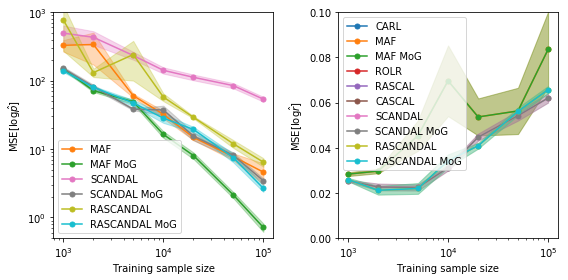

In [91]:
colors = ['C' + str(i) for i in range(10)]

fig = plt.figure(figsize=(8,4))



ax = plt.subplot(1,2,1)

for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.fill_between(
            sample_sizes,
            log_p_grid_mse_mean[m] - log_p_grid_mse_uncertainties[m],
            log_p_grid_mse_mean[m] + log_p_grid_mse_uncertainties[m],
            color=colors[m],
            alpha=0.3
        )
    
for m, method in enumerate(legend_labels):
    if np.any(np.isfinite(log_p_grid_mse_mean[m])):
        plt.plot(
            sample_sizes,
            log_p_grid_mse_mean[m],
            color=colors[m],
            lw=1.5,
            ls='-',
            marker='o',
            ms=5.,
            label=method
        )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel(r'$\mathrm{MSE} [ \log \hat{p} ] $')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
plt.ylim(0.5,1000.)



ax = plt.subplot(1,2,2)

for m, method in enumerate(legend_labels):
    plt.fill_between(
        sample_sizes,
        log_r_grid_mse_mean[m] - log_r_grid_mse_uncertainties[m],
        log_r_grid_mse_mean[m] + log_r_grid_mse_uncertainties[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(legend_labels):
    plt.plot(
        sample_sizes,
        log_r_grid_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel(r'$\mathrm{MSE} [ \log \hat{r} ] $')
ax.set_xscale("log", nonposx='clip')
plt.ylim(0.,0.1)
    
    

plt.tight_layout()
plt.savefig('grid_metrics.pdf')


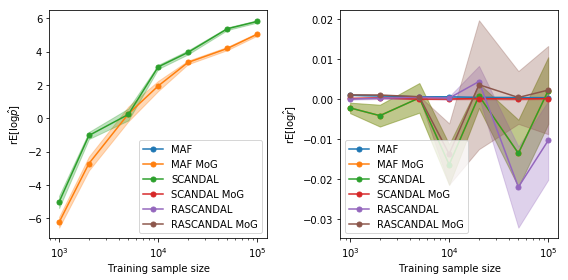

In [87]:
colors = ['C' + str(i) for i in range(10)]

fig = plt.figure(figsize=(8,4))



ax = plt.subplot(1,2,1)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        expected_log_p_grid_mean[m] - expected_log_p_grid_uncertainties[m],
        expected_log_p_grid_mean[m] + expected_log_p_grid_uncertainties[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        expected_log_p_grid_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('r$\mathrm{E} [ \log \hat{p} ] $')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(0.,5000.)



ax = plt.subplot(1,2,2)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        expected_log_r_grid_mean[m] - expected_log_r_grid_uncertainties[m],
        expected_log_r_grid_mean[m] + expected_log_r_grid_uncertainties[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        expected_log_r_grid_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('r$\mathrm{E} [ \log \hat{r} ] $')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(0.,200.)
    
    

plt.tight_layout()
plt.show()


## Original vs simulated samples

In [154]:
x_simulator = np.load('../../data/samples/lotkavolterra/x_test_focus_singletheta.npy')
x_maf = np.load('../../data/results/lotkavolterra/maf/samples_from_p_hat_trainingsamplesize_200000.npy')
x_scandal = np.load('../../data/results/lotkavolterra/scandal/samples_from_p_hat_trainingsamplesize_200000.npy')
x_rascandal = np.load('../../data/results/lotkavolterra/rascandal/samples_from_p_hat_trainingsamplesize_200000.npy')


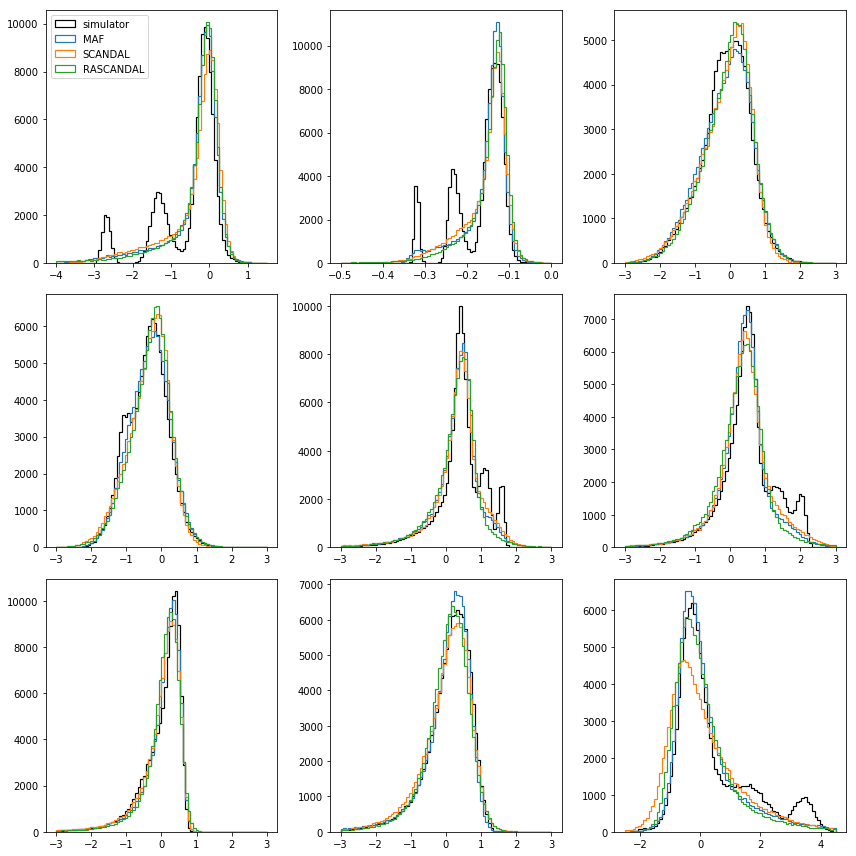

In [161]:
ranges = [(-3., 3.) for _ in range(9)]
ranges[0] = (-4.,1.5)
ranges[1] = (-0.5,0.)
ranges[8] = (-2.5,4.5)
bins = 80

plt.figure(figsize=(12,12))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
       
    plt.hist(x_simulator[:,i], histtype='step', range=ranges[i], bins=bins, lw=1.2, label='simulator', color='black') 
    plt.hist(x_maf[:,i], histtype='step', range=ranges[i], bins=bins, lw=1.2, label='MAF') 
    plt.hist(x_scandal[:,i], histtype='step', range=ranges[i], bins=bins, lw=1.2, label='SCANDAL') 
    plt.hist(x_rascandal[:,i], histtype='step', range=ranges[i], bins=bins, lw=1.2, label='RASCANDAL')
    
    if i == 0:
        plt.legend(loc='upper left')
    
plt.tight_layout()
plt.savefig('x_distribution.pdf')

In [ ]:
fig = corner.corner(x_maf[::],
                   range=ranges,
                   bins=[50 for _ in range(9)],
                   color='C0', alpha=0.5)
_ = corner.corner(x_simulator[::],
                   fig=fig,
                   range=ranges,
                   bins=[50 for _ in range(9)],
                   color='black', alpha=0.5)

plt.savefig('corner.pdf')